In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Business Analyst Phase/EDA-I/combined_nifty_50_data.csv')

#Initial Tasks

##1. Data Acquisition and Preparation

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

In [ ]:
max_date = df['Date'].max()
five_years_ago = max_date - pd.DateOffset(years=5)
df = df[df['Date'] >= five_years_ago]

In [ ]:
top_20_stocks = df.groupby('Stock')['Volume'].mean().sort_values(ascending=False).head(20).index.tolist()
df = df[df['Stock'].isin(top_20_stocks)]

In [ ]:
required_columns = ['Stock', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume']
df = df[required_columns]

#2. Data Cleaning

In [ ]:
df = df.dropna(subset=['Date', 'Stock', 'Open', 'Close'])

In [ ]:
for col in ['High', 'Low', 'Volume']:
    if df[col].isnull().any():
        df[col] = df[col].interpolate(method='linear')

In [ ]:
for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
    df = df[df[col] > 0]

In [ ]:
df = df.drop_duplicates()

#3. Strategy Implementation

#4. Define Moving Averages

In [ ]:
short_window = 20
long_window = 50

df['SMA_short'] = df.groupby('Stock')['Close'].transform(lambda x: x.rolling(window=short_window, min_periods=1).mean())
df['SMA_long'] = df.groupby('Stock')['Close'].transform(lambda x: x.rolling(window=long_window, min_periods=1).mean())

In [ ]:
df = df.sort_values(['Stock', 'Date']).copy()

#5. Generate Buy/Sell Signals

In [ ]:
def generate_signals(group):
    group = group.copy()
    group['Signal'] = ''

    short = group['SMA_short']
    long = group['SMA_long']

    prev_short = short.shift(1)
    prev_long = long.shift(1)

    # Buy signal: short crosses above long or from equal to above
    buy_mask = ((short > long) & (prev_short <= prev_long)) | ((short == long) & (prev_short < prev_long))

    # Sell signal: short crosses below long or from equal to below
    sell_mask = ((short < long) & (prev_short >= prev_long)) | ((short == long) & (prev_short > prev_long))

    group.loc[buy_mask, 'Signal'] = 'Buy'
    group.loc[sell_mask, 'Signal'] = 'Sell'

    print(f"{group['Stock'].iloc[0]}: Buy signals={buy_mask.sum()}, Sell signals={sell_mask.sum()}")
    return group

In [ ]:
df = df.groupby('Stock').apply(generate_signals).reset_index(drop=True)

ADANI_PORTS: Buy signals=15, Sell signals=14
AXIS_BANK: Buy signals=13, Sell signals=12
BHARAT PETROLEUM: Buy signals=14, Sell signals=14
BHARTI_AIRTEL: Buy signals=13, Sell signals=13
COAL INDIA: Buy signals=16, Sell signals=16
HDFC_BANK: Buy signals=18, Sell signals=18
HINDALCO: Buy signals=12, Sell signals=13
ICICI_BANK: Buy signals=13, Sell signals=13
INDUS INDUSTRIES: Buy signals=12, Sell signals=12
INFOSYS: Buy signals=13, Sell signals=12
ITC: Buy signals=12, Sell signals=11
JSW STEEL: Buy signals=14, Sell signals=14
NTPC: Buy signals=18, Sell signals=18
ONGC: Buy signals=13, Sell signals=13
POWERGRID: Buy signals=16, Sell signals=16
RELIANCE: Buy signals=18, Sell signals=17
SBI_BANK: Buy signals=13, Sell signals=13
TATA MOTORS: Buy signals=15, Sell signals=15
TATA STEEL: Buy signals=10, Sell signals=10
WIPRO: Buy signals=14, Sell signals=13


/tmp/ipython-input-145304263.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Stock').apply(generate_signals).reset_index(drop=True)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24692 entries, 0 to 24691
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Stock      24692 non-null  object        
 1   Date       24692 non-null  datetime64[ns]
 2   Open       24692 non-null  float64       
 3   High       24692 non-null  float64       
 4   Low        24692 non-null  float64       
 5   Close      24692 non-null  float64       
 6   Volume     24692 non-null  float64       
 7   SMA_short  24692 non-null  float64       
 8   SMA_long   24692 non-null  float64       
 9   Signal     24692 non-null  object        
dtypes: datetime64[ns](1), float64(7), object(2)
memory usage: 1.9+ MB


In [ ]:
import numpy as np

In [ ]:
def calculate_yearly_performance(df):
    results = []

    df = df.sort_values(['Stock', 'Date']).copy()

    for stock, group in df.groupby('Stock'):
        group = group.reset_index(drop=True)
        group['Return'] = group['Close'].pct_change()

        group['Position'] = 0
        position = 0
        for i in range(1, len(group)):
            if group.loc[i-1, 'Signal'] == 'Buy':
                position = 1
            elif group.loc[i-1, 'Signal'] == 'Sell':
                position = 0
            group.loc[i, 'Position'] = position

        group['Strategy_Return'] = group['Return'] * group['Position']

        group['Year'] = group['Date'].dt.year

        for year, yr_data in group.groupby('Year'):
            total_return = (yr_data['Strategy_Return'] + 1).prod() - 1
            days = (yr_data['Date'].max() - yr_data['Date'].min()).days or 1
            annualized_return = (1 + total_return) ** (252 / days) - 1

            cumulative = (yr_data['Strategy_Return'] + 1).cumprod()
            peak = cumulative.cummax()
            drawdown = (cumulative - peak) / peak
            max_drawdown = drawdown.min()

            mean_ret = yr_data['Strategy_Return'].mean()
            std_ret = yr_data['Strategy_Return'].std()
            sharpe_ratio = (mean_ret / std_ret) * np.sqrt(252) if std_ret != 0 else 0

            trades = yr_data['Signal'].value_counts()
            wins = ((yr_data['Strategy_Return'] > 0) & (yr_data['Position'] == 1)).sum()
            losses = ((yr_data['Strategy_Return'] <= 0) & (yr_data['Position'] == 1)).sum()
            win_loss_ratio = wins / losses if losses > 0 else np.nan

            results.append({
                'Stock': stock,
                'Year': year,
                'Total_Return': total_return,
                'Annualized_Return': annualized_return,
                'Max_Drawdown': max_drawdown,
                'Sharpe_Ratio': sharpe_ratio,
                'Win_Loss_Ratio': win_loss_ratio,
                'Number_of_Trades': trades.get('Buy', 0)
            })

    return pd.DataFrame(results)

performance_yearly = calculate_yearly_performance(df)

In [ ]:
performance_yearly

,Stock,Year,Total_Return,Annualized_Return,Max_Drawdown,Sharpe_Ratio,Win_Loss_Ratio,Number_of_Trades
0,ADANI_PORTS,2018,-0.001752,-0.002335,-0.120679,0.084015,1.000000,2
1,ADANI_PORTS,2019,-0.229658,-0.165262,-0.252037,-0.927570,0.813333,2
2,ADANI_PORTS,2020,0.288297,0.191122,-0.210434,1.095087,0.974026,4
3,ADANI_PORTS,2021,0.475589,0.309110,-0.263715,1.248138,1.059524,2
4,ADANI_PORTS,2022,-0.115909,-0.082404,-0.270820,-0.306076,1.028169,4
...,...,...,...,...,...,...,...,...
115,WIPRO,2019,-0.118039,-0.083286,-0.260386,-0.681530,0.969697,2
116,WIPRO,2020,0.958700,0.590662,-0.115099,2.383106,1.200000,2
117,WIPRO,2021,0.580963,0.373141,-0.106100,2.102257,1.309524,2
118,WIPRO,2022,-0.358897,-0.266798,-0.388800,-3.114098,0.673913,3


#Objective Questions

##1a. Total returns for top 20 stocks over time.

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
df = df.sort_values(['Stock', 'Date']).copy()
df['Return'] = df.groupby('Stock')['Close'].pct_change()
df['Cumulative_Return'] = (1 + df['Return']).groupby(df['Stock']).cumprod() - 1

In [ ]:
top_20_stocks = df.groupby('Stock')['Volume'].mean().sort_values(ascending=False).head(20).index.tolist()
df_top_20 = df[df['Stock'].isin(top_20_stocks)]


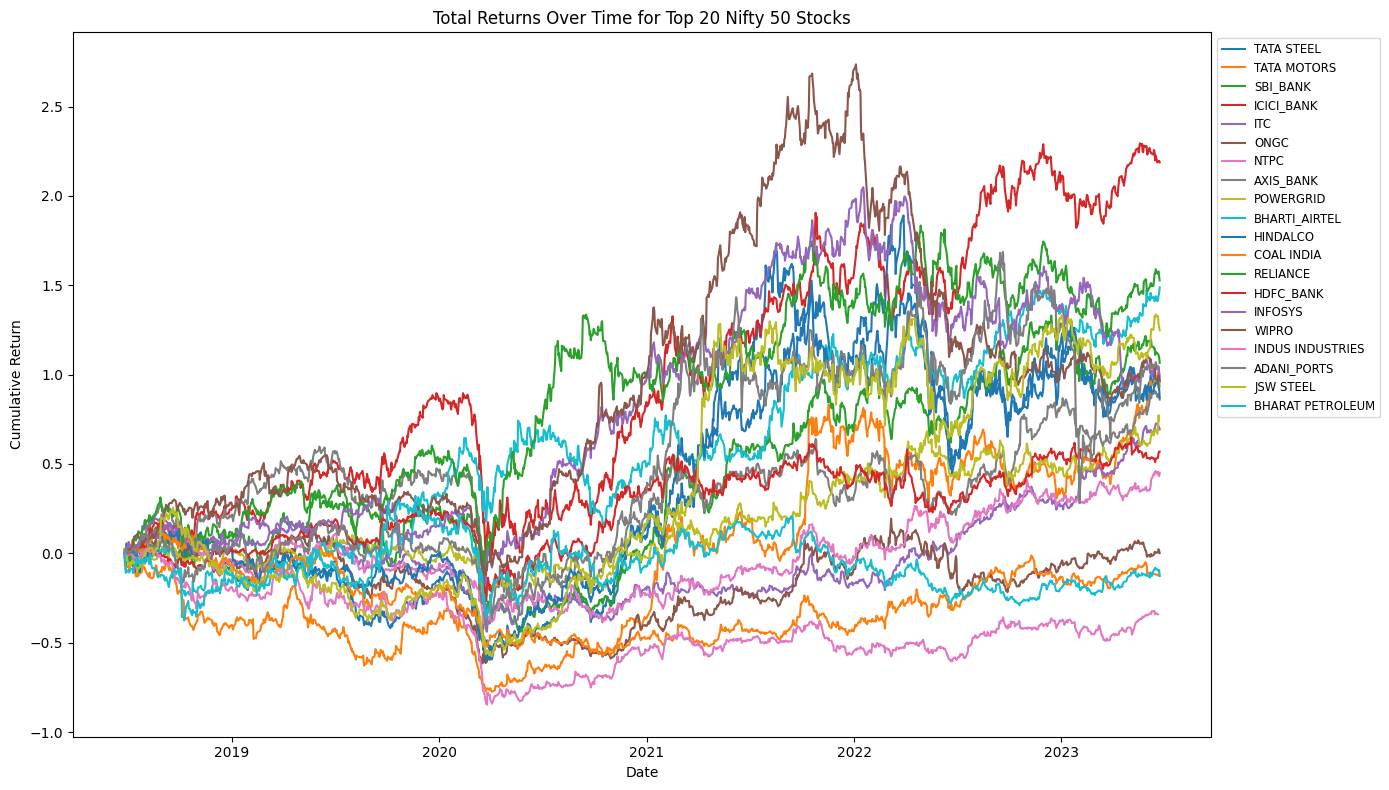

In [ ]:
plt.figure(figsize=(14, 8))
for stock in top_20_stocks:
    temp = df_top_20[df_top_20['Stock'] == stock]
    plt.plot(temp['Date'], temp['Cumulative_Return'], label=stock)


plt.title('Total Returns Over Time for Top 20 Nifty 50 Stocks')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
plt.tight_layout()
plt.show()

##1b. Cumulative returns over time of the selected stocks (Taking first 5 stocks after sorting the data).


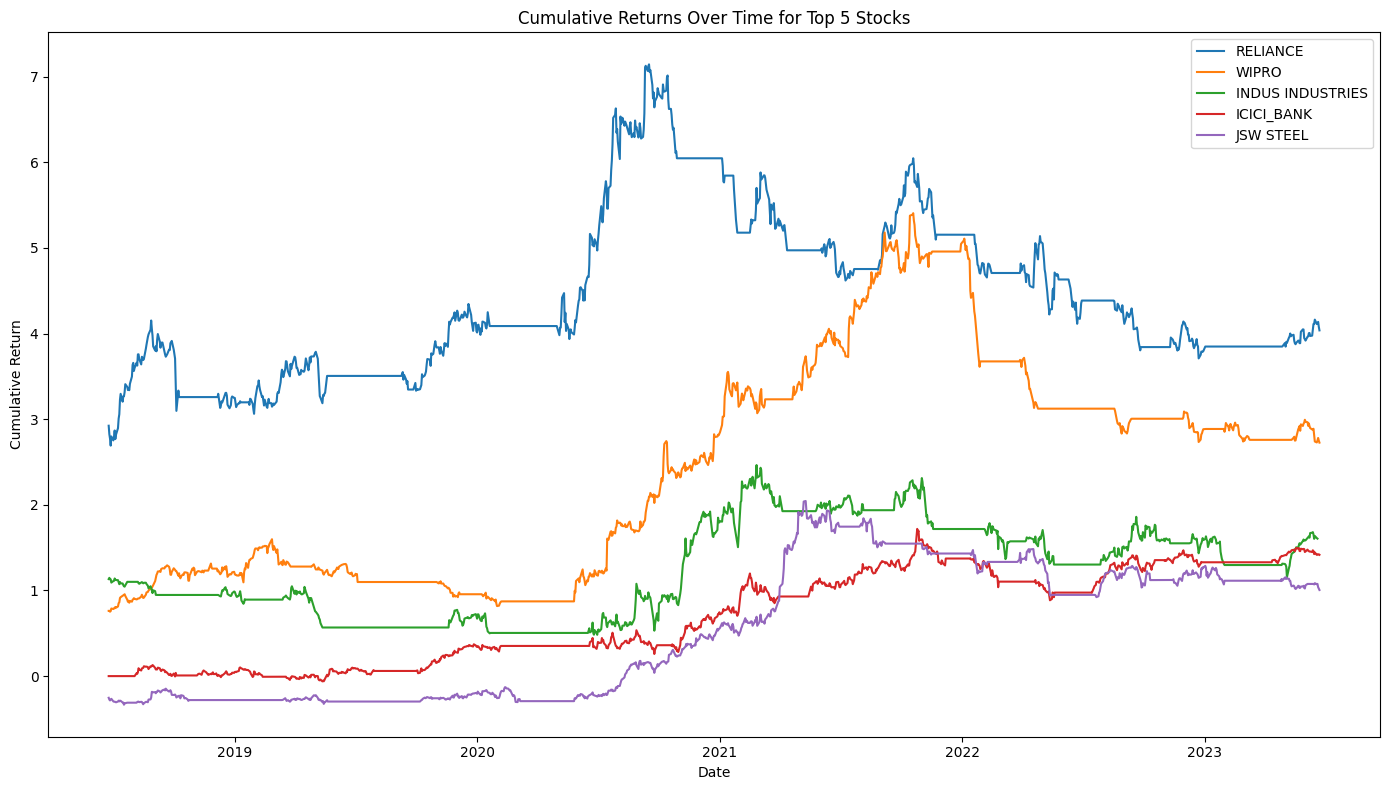

In [ ]:

df = df.sort_values(['Stock', 'Date']).copy()

df['Return'] = df['Close'].pct_change()

df['Position'] = 0
position = 0
for i in range(1, len(df)):
    if df.iloc[i-1]['Signal'] == 'Buy':
        position = 1
    elif df.iloc[i-1]['Signal'] == 'Sell':
        position = 0
    df.at[df.index[i], 'Position'] = position

df['Strategy_Return'] = df['Return'] * df['Position']

df['Cumulative_Return'] = df.groupby('Stock')['Strategy_Return'].transform(lambda x: (1 + x).cumprod() - 1)

top_20_stocks = df.groupby('Stock')['Strategy_Return'].mean().sort_values(ascending=False).head(20).index.tolist()

top_5_stocks = top_20_stocks[:5]
df_top5 = df[df['Stock'].isin(top_5_stocks)]

plt.figure(figsize=(14, 8))

for stock in top_5_stocks:
    stock_data = df_top5[df_top5['Stock'] == stock]
    plt.plot(stock_data['Date'], stock_data['Cumulative_Return'], label=stock)

plt.title('Cumulative Returns Over Time for Top 5 Stocks')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


##1c. Sharpe ratio vs. total return of first 20 stocks after sorting the data

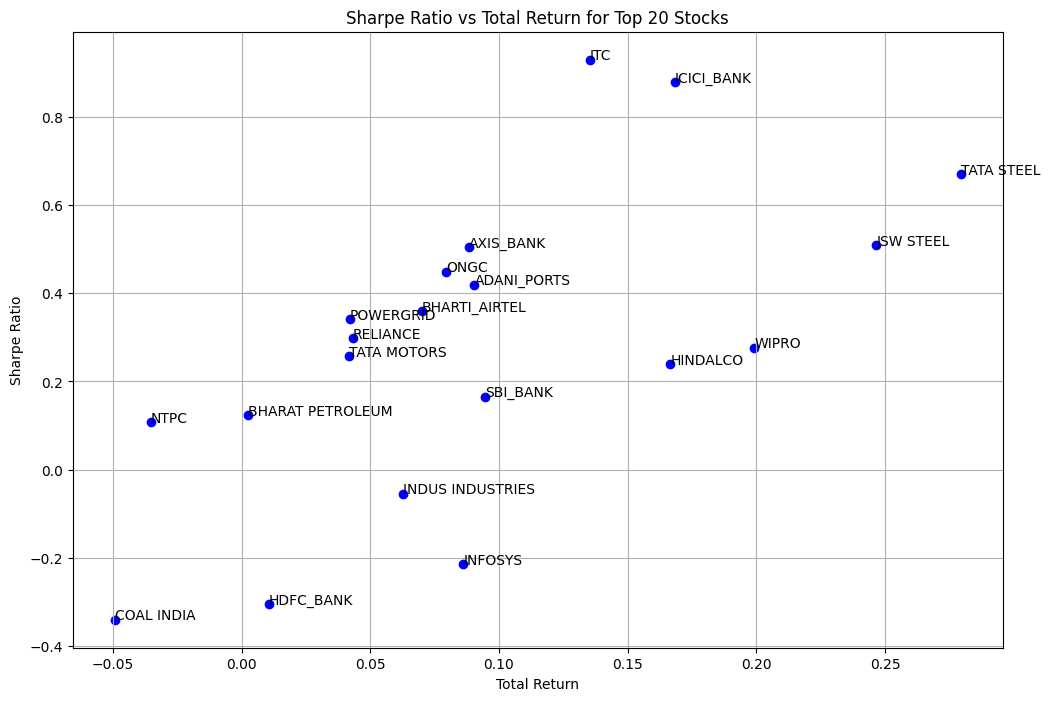

In [ ]:
top_20_perf = performance_yearly.groupby('Stock').mean().sort_values(by='Total_Return', ascending=False).head(20)

plt.figure(figsize=(12, 8))
plt.scatter(top_20_perf['Total_Return'], top_20_perf['Sharpe_Ratio'], color='blue')

for stock in top_20_perf.index:
    plt.annotate(stock, (top_20_perf.loc[stock, 'Total_Return'], top_20_perf.loc[stock, 'Sharpe_Ratio']))

plt.title('Sharpe Ratio vs Total Return for Top 20 Stocks')
plt.xlabel('Total Return')
plt.ylabel('Sharpe Ratio')
plt.grid(True)
plt.show()

##2. Generate a pair plot of selected performance metrics (total return, Sharpe ratio, max drawdown) for the stocks. What insights can you derive from the relationships between these metrics?

In [ ]:
import seaborn as sns

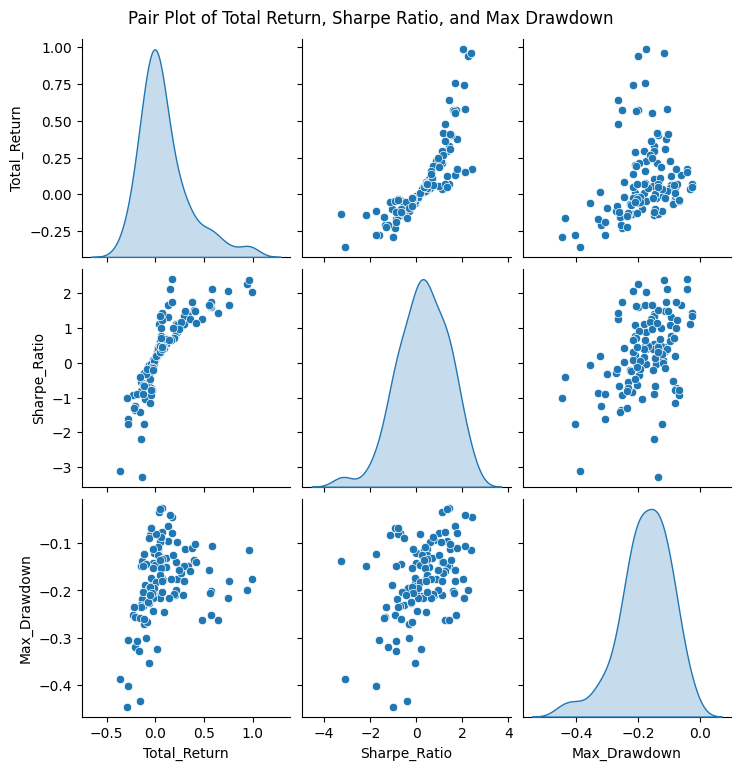

In [ ]:
df_metrics = performance_yearly[['Total_Return', 'Sharpe_Ratio', 'Max_Drawdown']].dropna()

sns.pairplot(df_metrics, diag_kind='kde')
plt.suptitle('Pair Plot of Total Return, Sharpe Ratio, and Max Drawdown', y=1.02)
plt.show()

##3. Which stock has shown the highest total return over the analyzed period?



In [ ]:
top_stock = performance_yearly.groupby('Stock')['Total_Return'].sum().idxmax()
top_return = performance_yearly.groupby('Stock')['Total_Return'].sum().max()

In [ ]:
top_stock

'TATA STEEL'

In [ ]:
top_return

1.6760518000284634

##4. Which stock has the lowest maximum drawdown, indicating stability?

In [ ]:
most_stable_stock = performance_yearly.groupby('Stock')['Max_Drawdown'].min().idxmax()
lowest_drawdown = performance_yearly.groupby('Stock')['Max_Drawdown'].min().max()

In [ ]:
most_stable_stock

'ITC'

In [ ]:
lowest_drawdown

-0.1777712653008529

##5. What are the best and worst months for each stock in terms of returns?

In [ ]:
df['YearMonth'] = df['Date'].dt.to_period('M')
monthly_returns = df.groupby(['Stock', 'YearMonth'])['Strategy_Return'].sum().reset_index()
best_months = monthly_returns.loc[monthly_returns.groupby('Stock')['Strategy_Return'].idxmax()][['Stock', 'YearMonth', 'Strategy_Return']]
worst_months = monthly_returns.loc[monthly_returns.groupby('Stock')['Strategy_Return'].idxmin()][['Stock', 'YearMonth', 'Strategy_Return']]

print("Best months:")
print(best_months)

print("Worst months")
print(worst_months)


Best months:
                 Stock YearMonth  Strategy_Return
32         ADANI_PORTS   2021-02         0.290220
113          AXIS_BANK   2022-10         0.217547
137   BHARAT PETROLEUM   2019-09         0.216611
200      BHARTI_AIRTEL   2019-11         0.179153
283         COAL INDIA   2021-09         0.136436
334          HDFC_BANK   2020-11         0.201106
398           HINDALCO   2021-02         0.419982
456         ICICI_BANK   2020-11         0.195085
488   INDUS INDUSTRIES   2018-06         1.113998
574            INFOSYS   2020-07         0.281788
633                ITC   2020-05         0.133462
705          JSW STEEL   2021-04         0.443381
771               NTPC   2021-09         0.120145
823               ONGC   2020-12         0.181274
886          POWERGRID   2021-02         0.158351
915           RELIANCE   2018-06         2.893042
1008          SBI_BANK   2021-02         0.342055
1047       TATA MOTORS   2019-04         0.242452
1127        TATA STEEL   2020-11     

##6. Which stocks have the highest average trading volume?

In [ ]:
avg_volume = df.groupby('Stock')['Volume'].mean().sort_values(ascending=False)
avg_volume.head(5)

,Volume
Stock,
TATA STEEL,1.138656e+08
TATA MOTORS,3.734508e+07
SBI_BANK,3.199627e+07
ICICI_BANK,2.124040e+07
ITC,1.972753e+07


##7. What is the total number of trades executed for each stock?

In [ ]:
num_trades = df.groupby('Stock')['Signal'].apply(lambda x: (x == 'Buy').sum()).sort_values(ascending=False)
num_trades

,Signal
Stock,
NTPC,18
RELIANCE,18
HDFC_BANK,18
COAL INDIA,16
POWERGRID,16
TATA MOTORS,15
ADANI_PORTS,15
BHARAT PETROLEUM,14
JSW STEEL,14


##8. Which stock had the maximum single-day loss (highest negative daily return) during the analysis period?

In [ ]:
worst_loss_idx = df.groupby('Stock')['Return'].idxmin()
worst_loss = df.loc[worst_loss_idx, ['Stock', 'Date', 'Return']].sort_values(by='Return').head(1)

In [ ]:
worst_loss

,Stock,Date,Return
22222,TATA STEEL,2018-06-25,-0.900188


##9. Which stock had the maximum single-day gain (highest positive daily return) during the analysis period?

In [ ]:
best_gain_idx = df.groupby('Stock')['Return'].idxmax()

best_gain = df.loc[best_gain_idx, ['Stock', 'Date', 'Return']].sort_values(by='Return', ascending=False).head(1)

In [ ]:
best_gain

,Stock,Date,Return
6171,HDFC_BANK,2018-06-25,3.615444


##10. Which stock had the lowest average closing price over the analysis period?

In [ ]:
lowest_close_stock = df.groupby('Stock')['Close'].mean().idxmin()
lowest_close_value = df.groupby('Stock')['Close'].mean().min()

In [ ]:
lowest_close_stock

'TATA STEEL'

In [ ]:
lowest_close_value

77.27261126801619

#Subjective Questions

##1. How do the annualized returns compare across the top 20 stocks?

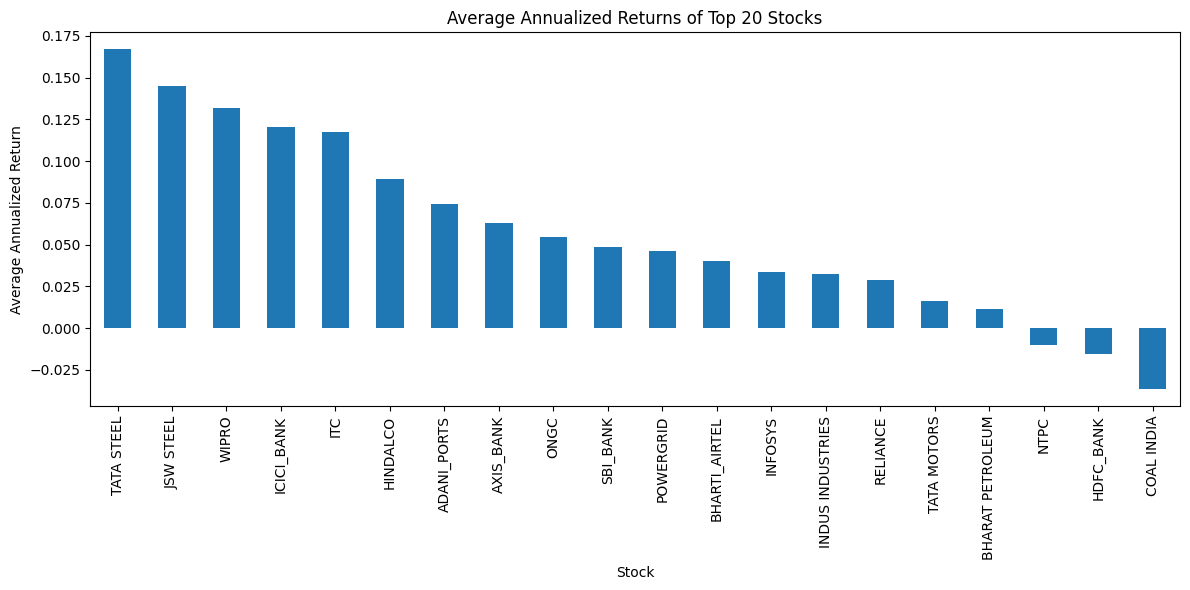

In [ ]:
top_20 = performance_yearly.groupby('Stock')['Annualized_Return'].mean().sort_values(ascending=False).head(20)

plt.figure(figsize=(12, 6))
top_20.plot(kind='bar')
plt.title('Average Annualized Returns of Top 20 Stocks')
plt.ylabel('Average Annualized Return')
plt.xlabel('Stock')
plt.tight_layout()
plt.show()

##2. What is the relationship between total return and trading volume for the stocks?

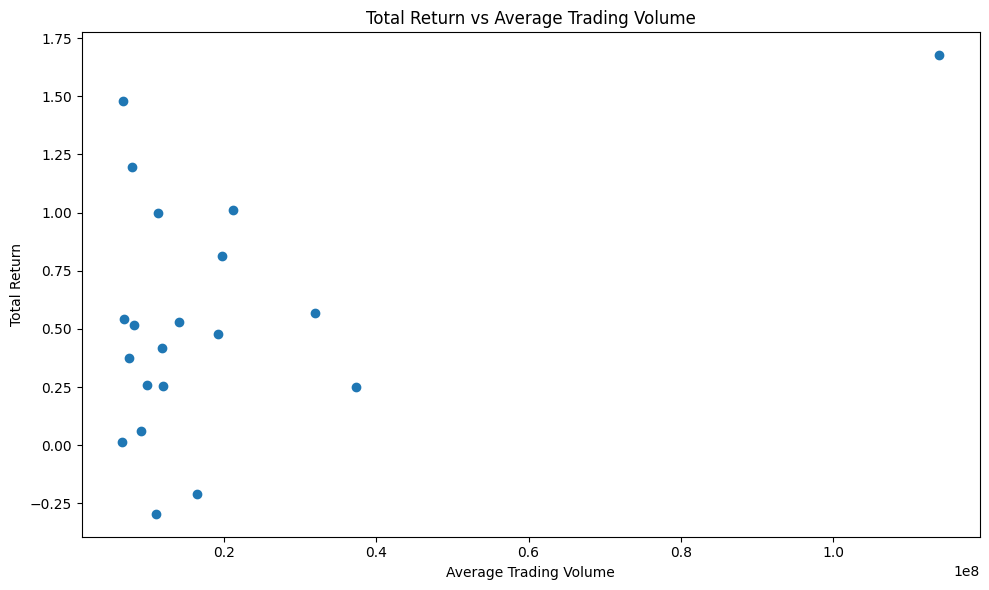

In [ ]:
avg_volume = df.groupby('Stock')['Volume'].mean()
total_return = performance_yearly.groupby('Stock')['Total_Return'].sum()

combined = pd.DataFrame({
    'Total_Return': total_return,
    'Avg_Volume': avg_volume
})

plt.figure(figsize=(10,6))
plt.scatter(combined['Avg_Volume'], combined['Total_Return'])
plt.xlabel('Average Trading Volume')
plt.ylabel('Total Return')
plt.title('Total Return vs Average Trading Volume')
plt.tight_layout()
plt.show()


In [ ]:
correlation = combined['Total_Return'].corr(combined['Avg_Volume'])
correlation

np.float64(0.46266831163080496)

##3. Generate a heatmap of the correlation matrix for the closing prices of the top 20 stocks. Which stocks are most correlated with each other?

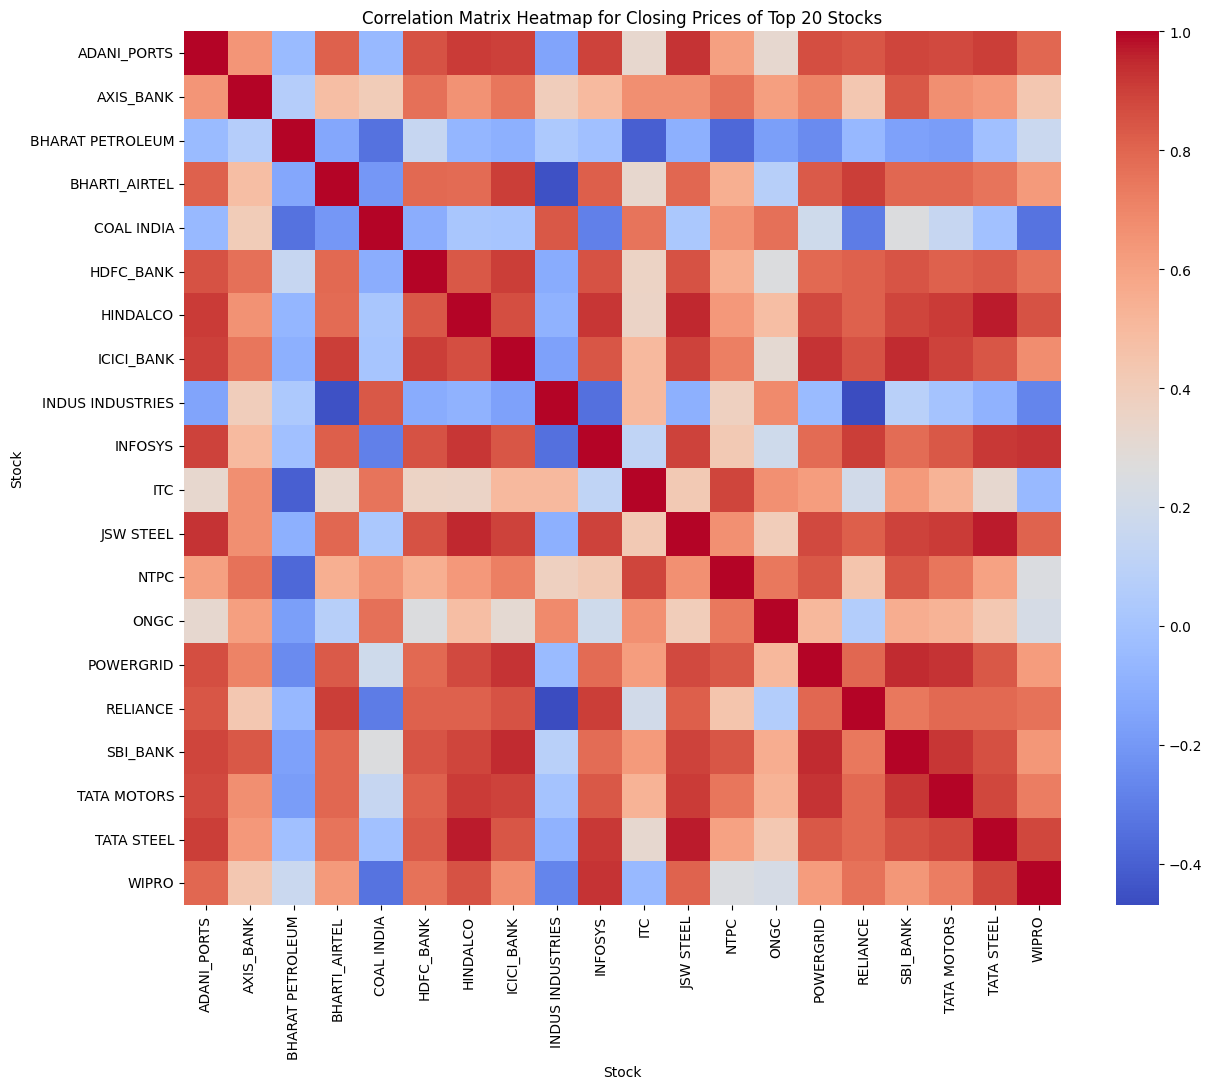

In [ ]:
top_20_stocks_list = (
    performance_yearly.groupby('Stock')['Annualized_Return']
    .mean().sort_values(ascending=False).head(20).index.tolist()
)

df_top20 = df[df['Stock'].isin(top_20_stocks_list)]
pivot = df_top20.pivot(index='Date', columns='Stock', values='Close')

corr_matrix = pivot.corr()

plt.figure(figsize=(13, 11))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap for Closing Prices of Top 20 Stocks')
plt.tight_layout()
plt.show()

##4. Perform backtesting of the top 20 Nifty 50 stocks using the moving average crossover strategy and evaluate their performance based on key metrics such as total returns, annualized returns, maximum drawdown, Sharpe ratio, win/loss ratio, and number of trades executed.

In [ ]:
top_20_stocks_list = (
    performance_yearly.groupby('Stock')['Annualized_Return']
    .mean().sort_values(ascending=False).head(20).index.tolist()
)

results = []

for stock in top_20_stocks_list:
    stock_df = df[df['Stock'] == stock].copy()
    stock_df['SMA20'] = stock_df['Close'].rolling(window=20).mean()
    stock_df['LMA50'] = stock_df['Close'].rolling(window=50).mean()

    stock_df['Signal'] = 0
    stock_df['Signal'][20:] = np.where(stock_df['SMA20'][20:] > stock_df['LMA50'][20:], 1, 0)
    stock_df['Position'] = stock_df['Signal'].diff()

    stock_df['Strategy_Return'] = stock_df['Close'].pct_change() * stock_df['Position'].shift(1)

    total_return = (stock_df['Strategy_Return'] + 1).prod() - 1
    annualized_return = (1 + total_return) ** (252 / len(stock_df)) - 1
    max_drawdown = (stock_df['Close'] / stock_df['Close'].cummax() - 1).min()
    sharpe_ratio = stock_df['Strategy_Return'].mean() / stock_df['Strategy_Return'].std() * np.sqrt(252)
    wins = (stock_df['Strategy_Return'] > 0).sum()
    losses = (stock_df['Strategy_Return'] < 0).sum()
    win_loss_ratio = wins / max(1, losses)
    trades_executed = abs(stock_df['Position']).sum()

    results.append({
        'Stock': stock,
        'Total_Return': total_return,
        'Annualized_Return': annualized_return,
        'Max_Drawdown': max_drawdown,
        'Sharpe_Ratio': sharpe_ratio,
        'Win_Loss_Ratio': win_loss_ratio,
        'Trades_Executed': trades_executed
    })

results_df = pd.DataFrame(results)
results_df

/tmp/ipython-input-519926993.py:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  stock_df['Signal'][20:] = np.where(stock_df['SMA20'][20:] > stock_df['LMA50'][20:], 1, 0)
/tmp/ipython-input-519926993.py:14: SettingWithCopyWarning: 
A value 

,Stock,Total_Return,Annualized_Return,Max_Drawdown,Sharpe_Ratio,Win_Loss_Ratio,Trades_Executed
0,TATA STEEL,0.033366,0.006720,-0.594097,0.171997,0.583333,19.0
1,JSW STEEL,-0.077617,-0.016351,-0.662630,-0.260541,0.687500,27.0
2,WIPRO,0.142989,0.027646,-0.506306,0.596335,1.700000,27.0
3,ICICI_BANK,0.085143,0.016813,-0.483072,0.489360,1.777778,25.0
4,ITC,0.022693,0.004589,-0.539628,0.186063,0.916667,23.0
5,HINDALCO,0.037074,0.007456,-0.653596,0.159844,1.181818,24.0
6,ADANI_PORTS,-0.075449,-0.015918,-0.523370,-0.392665,1.153846,29.0
7,AXIS_BANK,-0.105897,-0.022581,-0.631563,-0.411308,0.923077,25.0
8,ONGC,-0.029403,-0.006071,-0.670872,-0.088659,0.642857,24.0
9,SBI_BANK,-0.065193,-0.013662,-0.594925,-0.349618,1.083333,25.0
